In [281]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

from fedlab.main.fedlab_benchmarks.leaf.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    


In [282]:
print(torch.__version__)




2.0.1+cu117


In [283]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 10
epoch_total = 50
pickle_name = "mnist-epoch-"+str(epoch_total)

In [284]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [285]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [286]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [287]:
# train_dataset2 = torchvision.datasets.MNIST('datasets/', download=True, train=True, transform=transform, target_transform=target_transform),
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000000, num_workers=0)

# test_dataset = torchvision.datasets.MNIST('datasets/', download=True, train=False, transform=transform, target_transform=target_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000000, num_workers=0)


# Inital MNIST
train_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=True, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)
test_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=False, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)

train_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in train_datasets]
test_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in test_datasets]


In [288]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x0000025814D15180>, <torch.utils.data.dataloader.DataLoader object at 0x00000258148034F0>, <torch.utils.data.dataloader.DataLoader object at 0x0000025814803F10>, <torch.utils.data.dataloader.DataLoader object at 0x0000025814803700>, <torch.utils.data.dataloader.DataLoader object at 0x0000025814802BF0>]
2000


In [289]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

In [290]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 10)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        train_accuracy = []
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            train_accuracy.append(correct / total)
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = train_accuracy[-1]
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_accuracy = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
            test_accuracy.append(correct / total)
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = test_accuracy[-1]
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(0, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])
    







In [291]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [292]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc = []
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
        node.testing()
        #test_losses.append(node.test_loss)
        #print("Node Test Accuracy", node.test_accuracy)
        #print("Node Test loss", node.test_loss)
        #print("Node F1_Score ", node.f1_score)
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    averaged_state = {}
    for key in s_i[0].keys():
        param_value = 0
        for i in s_i:
            param_value += s_i[i][key]
        
        averaged_state[key] = param_value/num_nodes

    for node in nodes:
        node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 test loss: 2.260
Epoch 1 test loss: 2.269
Epoch 1 test loss: 2.260
Epoch 1 test loss: 2.260


  2%|▏         | 1/50 [00:12<09:50, 12.05s/it]

Epoch 1 test loss: 2.265
Epoch 1 test loss: 2.286
Epoch 1 test loss: 2.284
Epoch 1 test loss: 2.287
Epoch 1 test loss: 2.287


  4%|▍         | 2/50 [00:23<09:17, 11.62s/it]

Epoch 1 test loss: 2.286
Epoch 1 test loss: 2.272
Epoch 1 test loss: 2.269
Epoch 1 test loss: 2.273
Epoch 1 test loss: 2.273


  6%|▌         | 3/50 [00:34<08:58, 11.46s/it]

Epoch 1 test loss: 2.272
Epoch 1 test loss: 2.255
Epoch 1 test loss: 2.252
Epoch 1 test loss: 2.256
Epoch 1 test loss: 2.257


  8%|▊         | 4/50 [00:45<08:40, 11.31s/it]

Epoch 1 test loss: 2.255
Epoch 1 test loss: 2.237
Epoch 1 test loss: 2.233
Epoch 1 test loss: 2.238
Epoch 1 test loss: 2.238


 10%|█         | 5/50 [00:56<08:28, 11.29s/it]

Epoch 1 test loss: 2.235
Epoch 1 test loss: 2.216
Epoch 1 test loss: 2.212
Epoch 1 test loss: 2.217
Epoch 1 test loss: 2.218


 12%|█▏        | 6/50 [01:09<08:39, 11.81s/it]

Epoch 1 test loss: 2.215
Epoch 1 test loss: 2.194
Epoch 1 test loss: 2.188
Epoch 1 test loss: 2.195
Epoch 1 test loss: 2.195


 14%|█▍        | 7/50 [01:21<08:21, 11.67s/it]

Epoch 1 test loss: 2.192
Epoch 1 test loss: 2.169
Epoch 1 test loss: 2.163
Epoch 1 test loss: 2.171
Epoch 1 test loss: 2.171


 16%|█▌        | 8/50 [01:32<08:06, 11.58s/it]

Epoch 1 test loss: 2.167
Epoch 1 test loss: 2.144
Epoch 1 test loss: 2.137
Epoch 1 test loss: 2.146
Epoch 1 test loss: 2.145


 18%|█▊        | 9/50 [01:44<07:54, 11.58s/it]

Epoch 1 test loss: 2.141
Epoch 1 test loss: 2.117
Epoch 1 test loss: 2.109
Epoch 1 test loss: 2.119
Epoch 1 test loss: 2.117


 20%|██        | 10/50 [01:55<07:37, 11.44s/it]

Epoch 1 test loss: 2.113
Epoch 1 test loss: 2.088
Epoch 1 test loss: 2.079
Epoch 1 test loss: 2.090
Epoch 1 test loss: 2.088


 22%|██▏       | 11/50 [02:06<07:24, 11.39s/it]

Epoch 1 test loss: 2.083
Epoch 1 test loss: 2.057
Epoch 1 test loss: 2.047
Epoch 1 test loss: 2.059
Epoch 1 test loss: 2.057


 24%|██▍       | 12/50 [02:18<07:16, 11.50s/it]

Epoch 1 test loss: 2.052
Epoch 1 test loss: 2.025
Epoch 1 test loss: 2.014
Epoch 1 test loss: 2.027
Epoch 1 test loss: 2.025


 26%|██▌       | 13/50 [02:29<07:00, 11.38s/it]

Epoch 1 test loss: 2.019
Epoch 1 test loss: 1.992
Epoch 1 test loss: 1.980
Epoch 1 test loss: 1.994
Epoch 1 test loss: 1.992


 28%|██▊       | 14/50 [02:40<06:48, 11.34s/it]

Epoch 1 test loss: 1.985
Epoch 1 test loss: 1.958
Epoch 1 test loss: 1.945
Epoch 1 test loss: 1.959
Epoch 1 test loss: 1.957


 30%|███       | 15/50 [02:51<06:33, 11.25s/it]

Epoch 1 test loss: 1.950
Epoch 1 test loss: 1.922
Epoch 1 test loss: 1.908
Epoch 1 test loss: 1.923
Epoch 1 test loss: 1.921


 32%|███▏      | 16/50 [03:02<06:22, 11.25s/it]

Epoch 1 test loss: 1.913
Epoch 1 test loss: 1.886
Epoch 1 test loss: 1.870
Epoch 1 test loss: 1.886
Epoch 1 test loss: 1.884


 34%|███▍      | 17/50 [03:13<06:09, 11.20s/it]

Epoch 1 test loss: 1.875
Epoch 1 test loss: 1.847
Epoch 1 test loss: 1.831
Epoch 1 test loss: 1.848
Epoch 1 test loss: 1.845


 36%|███▌      | 18/50 [03:25<06:03, 11.35s/it]

Epoch 1 test loss: 1.836
Epoch 1 test loss: 1.808
Epoch 1 test loss: 1.790
Epoch 1 test loss: 1.808
Epoch 1 test loss: 1.805


 38%|███▊      | 19/50 [03:36<05:51, 11.33s/it]

Epoch 1 test loss: 1.796
Epoch 1 test loss: 1.768
Epoch 1 test loss: 1.749
Epoch 1 test loss: 1.767
Epoch 1 test loss: 1.765


 40%|████      | 20/50 [03:48<05:40, 11.35s/it]

Epoch 1 test loss: 1.754
Epoch 1 test loss: 1.727
Epoch 1 test loss: 1.707
Epoch 1 test loss: 1.726
Epoch 1 test loss: 1.723


 42%|████▏     | 21/50 [03:59<05:28, 11.34s/it]

Epoch 1 test loss: 1.712
Epoch 1 test loss: 1.686
Epoch 1 test loss: 1.664
Epoch 1 test loss: 1.684
Epoch 1 test loss: 1.681


 44%|████▍     | 22/50 [04:11<05:18, 11.39s/it]

Epoch 1 test loss: 1.670
Epoch 1 test loss: 1.644
Epoch 1 test loss: 1.622
Epoch 1 test loss: 1.641
Epoch 1 test loss: 1.638


 46%|████▌     | 23/50 [04:22<05:08, 11.42s/it]

Epoch 1 test loss: 1.627
Epoch 1 test loss: 1.602
Epoch 1 test loss: 1.579
Epoch 1 test loss: 1.598
Epoch 1 test loss: 1.595


 48%|████▊     | 24/50 [04:34<04:56, 11.41s/it]

Epoch 1 test loss: 1.583
Epoch 1 test loss: 1.559
Epoch 1 test loss: 1.536
Epoch 1 test loss: 1.555
Epoch 1 test loss: 1.553


 50%|█████     | 25/50 [04:45<04:42, 11.31s/it]

Epoch 1 test loss: 1.540
Epoch 1 test loss: 1.517
Epoch 1 test loss: 1.493
Epoch 1 test loss: 1.512
Epoch 1 test loss: 1.510


 52%|█████▏    | 26/50 [04:56<04:32, 11.34s/it]

Epoch 1 test loss: 1.497
Epoch 1 test loss: 1.475
Epoch 1 test loss: 1.450
Epoch 1 test loss: 1.469
Epoch 1 test loss: 1.467


 54%|█████▍    | 27/50 [05:07<04:18, 11.26s/it]

Epoch 1 test loss: 1.454
Epoch 1 test loss: 1.433
Epoch 1 test loss: 1.408
Epoch 1 test loss: 1.427
Epoch 1 test loss: 1.424


 56%|█████▌    | 28/50 [05:18<04:07, 11.25s/it]

Epoch 1 test loss: 1.411
Epoch 1 test loss: 1.392
Epoch 1 test loss: 1.366
Epoch 1 test loss: 1.385
Epoch 1 test loss: 1.382


 58%|█████▊    | 29/50 [05:29<03:55, 11.19s/it]

Epoch 1 test loss: 1.369
Epoch 1 test loss: 1.351
Epoch 1 test loss: 1.325
Epoch 1 test loss: 1.343
Epoch 1 test loss: 1.341


 60%|██████    | 30/50 [05:41<03:44, 11.21s/it]

Epoch 1 test loss: 1.327
Epoch 1 test loss: 1.311
Epoch 1 test loss: 1.285
Epoch 1 test loss: 1.302
Epoch 1 test loss: 1.300


 62%|██████▏   | 31/50 [05:52<03:34, 11.31s/it]

Epoch 1 test loss: 1.287
Epoch 1 test loss: 1.271
Epoch 1 test loss: 1.246
Epoch 1 test loss: 1.263
Epoch 1 test loss: 1.261


 64%|██████▍   | 32/50 [06:04<03:25, 11.41s/it]

Epoch 1 test loss: 1.247
Epoch 1 test loss: 1.233
Epoch 1 test loss: 1.208
Epoch 1 test loss: 1.224
Epoch 1 test loss: 1.222


 66%|██████▌   | 33/50 [06:15<03:14, 11.45s/it]

Epoch 1 test loss: 1.208
Epoch 1 test loss: 1.196
Epoch 1 test loss: 1.172
Epoch 1 test loss: 1.186
Epoch 1 test loss: 1.184


 68%|██████▊   | 34/50 [06:26<03:01, 11.34s/it]

Epoch 1 test loss: 1.171
Epoch 1 test loss: 1.160
Epoch 1 test loss: 1.136
Epoch 1 test loss: 1.149
Epoch 1 test loss: 1.147


 70%|███████   | 35/50 [06:38<02:50, 11.34s/it]

Epoch 1 test loss: 1.134
Epoch 1 test loss: 1.125
Epoch 1 test loss: 1.102
Epoch 1 test loss: 1.114
Epoch 1 test loss: 1.112


 72%|███████▏  | 36/50 [06:49<02:38, 11.29s/it]

Epoch 1 test loss: 1.099
Epoch 1 test loss: 1.092
Epoch 1 test loss: 1.068
Epoch 1 test loss: 1.080
Epoch 1 test loss: 1.078


 74%|███████▍  | 37/50 [07:00<02:26, 11.29s/it]

Epoch 1 test loss: 1.065
Epoch 1 test loss: 1.060
Epoch 1 test loss: 1.037
Epoch 1 test loss: 1.047
Epoch 1 test loss: 1.045


 76%|███████▌  | 38/50 [07:11<02:14, 11.23s/it]

Epoch 1 test loss: 1.032
Epoch 1 test loss: 1.029
Epoch 1 test loss: 1.006
Epoch 1 test loss: 1.015
Epoch 1 test loss: 1.013


 78%|███████▊  | 39/50 [07:23<02:03, 11.27s/it]

Epoch 1 test loss: 1.000
Epoch 1 test loss: 0.999
Epoch 1 test loss: 0.977
Epoch 1 test loss: 0.985
Epoch 1 test loss: 0.982


 80%|████████  | 40/50 [07:34<01:52, 11.22s/it]

Epoch 1 test loss: 0.970
Epoch 1 test loss: 0.971
Epoch 1 test loss: 0.949
Epoch 1 test loss: 0.956
Epoch 1 test loss: 0.953


 82%|████████▏ | 41/50 [07:45<01:41, 11.24s/it]

Epoch 1 test loss: 0.941
Epoch 1 test loss: 0.944
Epoch 1 test loss: 0.922
Epoch 1 test loss: 0.928
Epoch 1 test loss: 0.926


 84%|████████▍ | 42/50 [07:56<01:29, 11.19s/it]

Epoch 1 test loss: 0.913
Epoch 1 test loss: 0.918
Epoch 1 test loss: 0.897
Epoch 1 test loss: 0.902
Epoch 1 test loss: 0.899


 86%|████████▌ | 43/50 [08:07<01:18, 11.22s/it]

Epoch 1 test loss: 0.887
Epoch 1 test loss: 0.893
Epoch 1 test loss: 0.873
Epoch 1 test loss: 0.876
Epoch 1 test loss: 0.874


 88%|████████▊ | 44/50 [08:19<01:07, 11.26s/it]

Epoch 1 test loss: 0.861
Epoch 1 test loss: 0.870
Epoch 1 test loss: 0.850
Epoch 1 test loss: 0.852
Epoch 1 test loss: 0.849


 90%|█████████ | 45/50 [08:31<00:57, 11.44s/it]

Epoch 1 test loss: 0.837
Epoch 1 test loss: 0.848
Epoch 1 test loss: 0.828
Epoch 1 test loss: 0.829
Epoch 1 test loss: 0.826


 92%|█████████▏| 46/50 [08:43<00:47, 11.75s/it]

Epoch 1 test loss: 0.814
Epoch 1 test loss: 0.827
Epoch 1 test loss: 0.807
Epoch 1 test loss: 0.808
Epoch 1 test loss: 0.804


 94%|█████████▍| 47/50 [08:55<00:35, 11.77s/it]

Epoch 1 test loss: 0.792
Epoch 1 test loss: 0.806
Epoch 1 test loss: 0.787
Epoch 1 test loss: 0.787
Epoch 1 test loss: 0.783


 96%|█████████▌| 48/50 [09:06<00:23, 11.67s/it]

Epoch 1 test loss: 0.772
Epoch 1 test loss: 0.787
Epoch 1 test loss: 0.768
Epoch 1 test loss: 0.767
Epoch 1 test loss: 0.763


 98%|█████████▊| 49/50 [09:19<00:11, 11.86s/it]

Epoch 1 test loss: 0.752
Epoch 1 test loss: 0.769
Epoch 1 test loss: 0.750
Epoch 1 test loss: 0.748
Epoch 1 test loss: 0.744


100%|██████████| 50/50 [09:31<00:00, 11.42s/it]

Epoch 1 test loss: 0.733
Time taken by FL with SMPC 571.0543472766876


In [293]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [294]:
result["train_accuracies"] = train_accuracies
result["train_losses"] = losses
result["test_accuracies"] = test_accuracies
result["test_losses"] = test_losses
result["f1_scores"] = f1_scores
result["ypred"] = ypred
result["ylabels"] = ylabels
result["time_taken"] = time_FL_SMPC


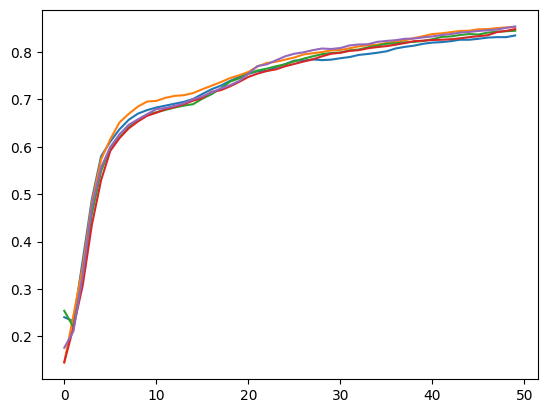

In [295]:
plt.plot(test_accuracies)

In [296]:
print(losses)

[[2.297895908355713, 2.3079075813293457, 2.2986345291137695, 2.2969000339508057, 2.3103888034820557], [2.296764373779297, 2.296278715133667, 2.296628952026367, 2.296369791030884, 2.2967894077301025], [2.2858994007110596, 2.28562331199646, 2.285951852798462, 2.2854745388031006, 2.2859013080596924], [2.2718303203582764, 2.271791458129883, 2.2721097469329834, 2.271371364593506, 2.2718005180358887], [2.2552435398101807, 2.2554681301116943, 2.255801200866699, 2.254803419113159, 2.2551896572113037], [2.2366364002227783, 2.2371480464935303, 2.2374823093414307, 2.236257553100586, 2.236584186553955], [2.2160940170288086, 2.216916084289551, 2.2172656059265137, 2.2157413959503174, 2.2160887718200684], [2.193789005279541, 2.1949002742767334, 2.195282459259033, 2.1933887004852295, 2.1938304901123047], [2.16963267326355, 2.171078681945801, 2.1714940071105957, 2.1691901683807373, 2.1697421073913574], [2.143738031387329, 2.14559268951416, 2.1460177898406982, 2.1432833671569824, 2.1439261436462402], [2

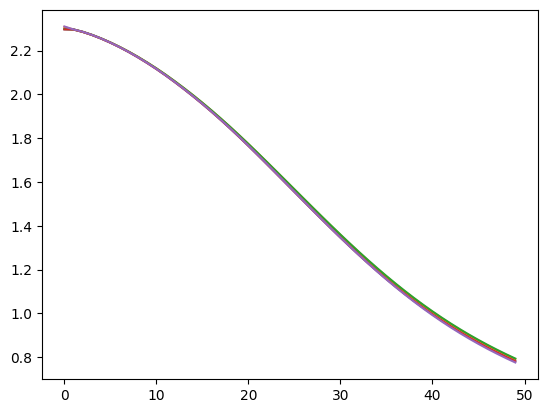

In [297]:
plt.plot(losses)

In [298]:

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [299]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):

        node.testing()
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)
    
    av_state = {}
    
    
    
    states = [i.network.state_dict() for i in nodes]
    av_state = {}
    for key in states[0]:
        av_state[key] = sum([s[key] for s in states])/num_nodes
    for node in nodes:
        node.network.load_state_dict(av_state)

time_FL = time.time() - start_time

print("Time taken by FL without SMPC", time_FL)
    

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 test loss: 2.270
Epoch 1 test loss: 2.259
Epoch 1 test loss: 2.253
Epoch 1 test loss: 2.254


  2%|▏         | 1/50 [00:11<09:23, 11.50s/it]

Epoch 1 test loss: 2.266
Epoch 1 test loss: 2.285
Epoch 1 test loss: 2.284
Epoch 1 test loss: 2.285
Epoch 1 test loss: 2.282


  4%|▍         | 2/50 [00:23<09:21, 11.69s/it]

Epoch 1 test loss: 2.283
Epoch 1 test loss: 2.269
Epoch 1 test loss: 2.267
Epoch 1 test loss: 2.269
Epoch 1 test loss: 2.265


  6%|▌         | 3/50 [00:34<09:03, 11.56s/it]

Epoch 1 test loss: 2.267
Epoch 1 test loss: 2.250
Epoch 1 test loss: 2.248
Epoch 1 test loss: 2.251
Epoch 1 test loss: 2.246


  8%|▊         | 4/50 [00:46<08:52, 11.57s/it]

Epoch 1 test loss: 2.248
Epoch 1 test loss: 2.230
Epoch 1 test loss: 2.227
Epoch 1 test loss: 2.230
Epoch 1 test loss: 2.226


 10%|█         | 5/50 [00:57<08:39, 11.53s/it]

Epoch 1 test loss: 2.227
Epoch 1 test loss: 2.207
Epoch 1 test loss: 2.204
Epoch 1 test loss: 2.208
Epoch 1 test loss: 2.203


 12%|█▏        | 6/50 [01:09<08:33, 11.67s/it]

Epoch 1 test loss: 2.204
Epoch 1 test loss: 2.184
Epoch 1 test loss: 2.179
Epoch 1 test loss: 2.184
Epoch 1 test loss: 2.179


 14%|█▍        | 7/50 [01:21<08:17, 11.56s/it]

Epoch 1 test loss: 2.180
Epoch 1 test loss: 2.159
Epoch 1 test loss: 2.154
Epoch 1 test loss: 2.159
Epoch 1 test loss: 2.154


 16%|█▌        | 8/50 [01:32<08:04, 11.54s/it]

Epoch 1 test loss: 2.155
Epoch 1 test loss: 2.133
Epoch 1 test loss: 2.126
Epoch 1 test loss: 2.133
Epoch 1 test loss: 2.127


 18%|█▊        | 9/50 [01:43<07:51, 11.50s/it]

Epoch 1 test loss: 2.128
Epoch 1 test loss: 2.105
Epoch 1 test loss: 2.098
Epoch 1 test loss: 2.106
Epoch 1 test loss: 2.100


 20%|██        | 10/50 [01:55<07:45, 11.65s/it]

Epoch 1 test loss: 2.100
Epoch 1 test loss: 2.076
Epoch 1 test loss: 2.068
Epoch 1 test loss: 2.077
Epoch 1 test loss: 2.070


 22%|██▏       | 11/50 [02:07<07:29, 11.54s/it]

Epoch 1 test loss: 2.070
Epoch 1 test loss: 2.046
Epoch 1 test loss: 2.036
Epoch 1 test loss: 2.047
Epoch 1 test loss: 2.040


 24%|██▍       | 12/50 [02:18<07:18, 11.53s/it]

Epoch 1 test loss: 2.039
Epoch 1 test loss: 2.014
Epoch 1 test loss: 2.004
Epoch 1 test loss: 2.015
Epoch 1 test loss: 2.008


 26%|██▌       | 13/50 [02:29<07:02, 11.43s/it]

Epoch 1 test loss: 2.007
Epoch 1 test loss: 1.981
Epoch 1 test loss: 1.970
Epoch 1 test loss: 1.982
Epoch 1 test loss: 1.975


 28%|██▊       | 14/50 [02:41<06:51, 11.43s/it]

Epoch 1 test loss: 1.974
Epoch 1 test loss: 1.947
Epoch 1 test loss: 1.935
Epoch 1 test loss: 1.948
Epoch 1 test loss: 1.941


 30%|███       | 15/50 [02:52<06:37, 11.36s/it]

Epoch 1 test loss: 1.939
Epoch 1 test loss: 1.912
Epoch 1 test loss: 1.898
Epoch 1 test loss: 1.913
Epoch 1 test loss: 1.906


 32%|███▏      | 16/50 [03:03<06:26, 11.37s/it]

Epoch 1 test loss: 1.903
Epoch 1 test loss: 1.876
Epoch 1 test loss: 1.861
Epoch 1 test loss: 1.877
Epoch 1 test loss: 1.869


 34%|███▍      | 17/50 [03:15<06:13, 11.31s/it]

Epoch 1 test loss: 1.867
Epoch 1 test loss: 1.839
Epoch 1 test loss: 1.822
Epoch 1 test loss: 1.840
Epoch 1 test loss: 1.832


 36%|███▌      | 18/50 [03:26<06:02, 11.34s/it]

Epoch 1 test loss: 1.829
Epoch 1 test loss: 1.801
Epoch 1 test loss: 1.784
Epoch 1 test loss: 1.802
Epoch 1 test loss: 1.794


 38%|███▊      | 19/50 [03:37<05:50, 11.30s/it]

Epoch 1 test loss: 1.790
Epoch 1 test loss: 1.763
Epoch 1 test loss: 1.744
Epoch 1 test loss: 1.764
Epoch 1 test loss: 1.756


 40%|████      | 20/50 [03:49<05:40, 11.33s/it]

Epoch 1 test loss: 1.751
Epoch 1 test loss: 1.724
Epoch 1 test loss: 1.704
Epoch 1 test loss: 1.725
Epoch 1 test loss: 1.717


 42%|████▏     | 21/50 [04:00<05:30, 11.41s/it]

Epoch 1 test loss: 1.712
Epoch 1 test loss: 1.685
Epoch 1 test loss: 1.665
Epoch 1 test loss: 1.685
Epoch 1 test loss: 1.678


 44%|████▍     | 22/50 [04:12<05:20, 11.43s/it]

Epoch 1 test loss: 1.672
Epoch 1 test loss: 1.646
Epoch 1 test loss: 1.624
Epoch 1 test loss: 1.645
Epoch 1 test loss: 1.638


 46%|████▌     | 23/50 [04:23<05:07, 11.39s/it]

Epoch 1 test loss: 1.631
Epoch 1 test loss: 1.606
Epoch 1 test loss: 1.584
Epoch 1 test loss: 1.605
Epoch 1 test loss: 1.598


 48%|████▊     | 24/50 [04:35<04:58, 11.48s/it]

Epoch 1 test loss: 1.591
Epoch 1 test loss: 1.566
Epoch 1 test loss: 1.543
Epoch 1 test loss: 1.564
Epoch 1 test loss: 1.558


 50%|█████     | 25/50 [04:46<04:45, 11.43s/it]

Epoch 1 test loss: 1.550
Epoch 1 test loss: 1.526
Epoch 1 test loss: 1.503
Epoch 1 test loss: 1.524
Epoch 1 test loss: 1.518


 52%|█████▏    | 26/50 [04:57<04:34, 11.43s/it]

Epoch 1 test loss: 1.509
Epoch 1 test loss: 1.486
Epoch 1 test loss: 1.463
Epoch 1 test loss: 1.483
Epoch 1 test loss: 1.478


 54%|█████▍    | 27/50 [05:09<04:21, 11.38s/it]

Epoch 1 test loss: 1.468
Epoch 1 test loss: 1.446
Epoch 1 test loss: 1.423
Epoch 1 test loss: 1.443
Epoch 1 test loss: 1.438


 56%|█████▌    | 28/50 [05:20<04:11, 11.42s/it]

Epoch 1 test loss: 1.428
Epoch 1 test loss: 1.407
Epoch 1 test loss: 1.383
Epoch 1 test loss: 1.403
Epoch 1 test loss: 1.398


 58%|█████▊    | 29/50 [05:31<03:58, 11.38s/it]

Epoch 1 test loss: 1.388
Epoch 1 test loss: 1.368
Epoch 1 test loss: 1.344
Epoch 1 test loss: 1.363
Epoch 1 test loss: 1.359


 60%|██████    | 30/50 [05:43<03:47, 11.40s/it]

Epoch 1 test loss: 1.348
Epoch 1 test loss: 1.330
Epoch 1 test loss: 1.306
Epoch 1 test loss: 1.324
Epoch 1 test loss: 1.320


 62%|██████▏   | 31/50 [05:54<03:36, 11.41s/it]

Epoch 1 test loss: 1.309
Epoch 1 test loss: 1.292
Epoch 1 test loss: 1.269
Epoch 1 test loss: 1.285
Epoch 1 test loss: 1.282


 64%|██████▍   | 32/50 [06:06<03:25, 11.42s/it]

Epoch 1 test loss: 1.270
Epoch 1 test loss: 1.255
Epoch 1 test loss: 1.232
Epoch 1 test loss: 1.248
Epoch 1 test loss: 1.245


 66%|██████▌   | 33/50 [06:17<03:13, 11.37s/it]

Epoch 1 test loss: 1.232
Epoch 1 test loss: 1.219
Epoch 1 test loss: 1.196
Epoch 1 test loss: 1.211
Epoch 1 test loss: 1.208


 68%|██████▊   | 34/50 [06:29<03:02, 11.42s/it]

Epoch 1 test loss: 1.195
Epoch 1 test loss: 1.184
Epoch 1 test loss: 1.161
Epoch 1 test loss: 1.175
Epoch 1 test loss: 1.172


 70%|███████   | 35/50 [06:40<02:50, 11.39s/it]

Epoch 1 test loss: 1.159
Epoch 1 test loss: 1.150
Epoch 1 test loss: 1.127
Epoch 1 test loss: 1.140
Epoch 1 test loss: 1.138


 72%|███████▏  | 36/50 [06:51<02:39, 11.40s/it]

Epoch 1 test loss: 1.124
Epoch 1 test loss: 1.117
Epoch 1 test loss: 1.095
Epoch 1 test loss: 1.106
Epoch 1 test loss: 1.104


 74%|███████▍  | 37/50 [07:03<02:27, 11.37s/it]

Epoch 1 test loss: 1.091
Epoch 1 test loss: 1.085
Epoch 1 test loss: 1.063
Epoch 1 test loss: 1.074
Epoch 1 test loss: 1.072


 76%|███████▌  | 38/50 [07:14<02:16, 11.39s/it]

Epoch 1 test loss: 1.058
Epoch 1 test loss: 1.054
Epoch 1 test loss: 1.032
Epoch 1 test loss: 1.042
Epoch 1 test loss: 1.040


 78%|███████▊  | 39/50 [07:25<02:04, 11.34s/it]

Epoch 1 test loss: 1.026
Epoch 1 test loss: 1.025
Epoch 1 test loss: 1.003
Epoch 1 test loss: 1.012
Epoch 1 test loss: 1.010


 80%|████████  | 40/50 [07:37<01:53, 11.37s/it]

Epoch 1 test loss: 0.996
Epoch 1 test loss: 0.996
Epoch 1 test loss: 0.974
Epoch 1 test loss: 0.982
Epoch 1 test loss: 0.980


 82%|████████▏ | 41/50 [07:48<01:41, 11.33s/it]

Epoch 1 test loss: 0.966
Epoch 1 test loss: 0.969
Epoch 1 test loss: 0.947
Epoch 1 test loss: 0.954
Epoch 1 test loss: 0.952


 84%|████████▍ | 42/50 [07:59<01:30, 11.37s/it]

Epoch 1 test loss: 0.938
Epoch 1 test loss: 0.943
Epoch 1 test loss: 0.921
Epoch 1 test loss: 0.928
Epoch 1 test loss: 0.926


 86%|████████▌ | 43/50 [08:11<01:20, 11.48s/it]

Epoch 1 test loss: 0.911
Epoch 1 test loss: 0.918
Epoch 1 test loss: 0.896
Epoch 1 test loss: 0.902
Epoch 1 test loss: 0.900


 88%|████████▊ | 44/50 [08:23<01:09, 11.59s/it]

Epoch 1 test loss: 0.886
Epoch 1 test loss: 0.894
Epoch 1 test loss: 0.873
Epoch 1 test loss: 0.877
Epoch 1 test loss: 0.875


 90%|█████████ | 45/50 [08:35<00:57, 11.57s/it]

Epoch 1 test loss: 0.861
Epoch 1 test loss: 0.871
Epoch 1 test loss: 0.850
Epoch 1 test loss: 0.854
Epoch 1 test loss: 0.851


 92%|█████████▏| 46/50 [08:46<00:46, 11.60s/it]

Epoch 1 test loss: 0.838
Epoch 1 test loss: 0.849
Epoch 1 test loss: 0.829
Epoch 1 test loss: 0.831
Epoch 1 test loss: 0.829


 94%|█████████▍| 47/50 [08:58<00:34, 11.57s/it]

Epoch 1 test loss: 0.815
Epoch 1 test loss: 0.829
Epoch 1 test loss: 0.808
Epoch 1 test loss: 0.810
Epoch 1 test loss: 0.807


 96%|█████████▌| 48/50 [09:10<00:23, 11.74s/it]

Epoch 1 test loss: 0.794
Epoch 1 test loss: 0.809
Epoch 1 test loss: 0.788
Epoch 1 test loss: 0.790
Epoch 1 test loss: 0.787


 98%|█████████▊| 49/50 [09:22<00:11, 11.98s/it]

Epoch 1 test loss: 0.773
Epoch 1 test loss: 0.790
Epoch 1 test loss: 0.770
Epoch 1 test loss: 0.770
Epoch 1 test loss: 0.767


100%|██████████| 50/50 [09:35<00:00, 11.51s/it]

Epoch 1 test loss: 0.754
Time taken by FL without SMPC 575.4542505741119


In [300]:
#print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [301]:
global_mean = 0.0
global_std = 0.0
eqn1= 0.0 
eqn2 = 0.0
eqn3 = 0.0
for node in nodes:
    eqn1 += node.mean * node.dataset_size
    eqn2 += node.dataset_size 
    eqn3 += node.std


global_mean = eqn1/eqn2
global_std = eqn3/eqn2
print("Global Mean", global_mean.shape)
print("Global std ", global_std.shape)
#plt.imshow(global_mean.squeeze())
#plt.imshow(global_std.squeeze())

Global Mean torch.Size([1, 28, 28])
Global std  torch.Size([1, 28, 28])


In [302]:
result2["train_accuracies"] = train_accuracies
result2["train_losses"] = losses
result2["test_accuracies"] = test_accuracies
result2["test_losses"] = test_losses
result2["f1_scores"] = f1_scores
result2["ypred"] = ypred
result2["ylabels"] = ylabels
result2["time_taken"] = time_FL


In [303]:
my_pickle_results["vanilla"] = result2
#print(my_pickle_results)
# pickle.dumps(my_pickle_results)
print(my_pickle_results["vanilla"]["time_taken"])

575.4542505741119


In [304]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [305]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])]


In [306]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-11 23:08:11
